# GARCH(1,1) Model

This notebook will implement GARCH(1,1) model for forecasting exchange rate volatility

In [68]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from arch import arch_model
from scipy.stats import norm
import datetime as dt
import pandas_datareader.data as web

Firstly, I read dataset using pandas datareader function, which receives KRW/USD dataset from FRED. The number of observation is 2609

In [69]:
start = dt.datetime(2010,10,30)
end = dt.datetime(2020,10,30)
currency_rate = web.DataReader('DEXKOUS', 'fred', start, end)
returns = 100 * currency_rate['DEXKOUS'].pct_change().dropna()
print(returns)

DATE
2010-11-02   -0.513105
2010-11-03   -0.108011
2010-11-04   -0.294648
2010-11-05    0.105736
2010-11-08    0.568746
                ...   
2020-10-26   -0.177027
2020-10-27    0.011527
2020-10-28    0.519550
2020-10-29   -0.232854
2020-10-30    0.253731
Name: DEXKOUS, Length: 2609, dtype: float64


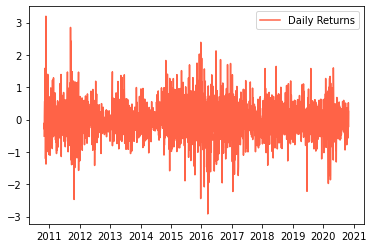

In [70]:
plt.plot(returns, color='tomato', label='Daily Returns')
plt.legend(loc='upper right')
plt.show()

In [71]:
vol_daily = returns.std()
print('Daily volatility: ', '{:.2f}%'.format(vol_daily))

Daily volatility:  0.52%


From now on, I am going to apply dataset to garch model, which is formulated as normal distribution and constant mean assumption

In [72]:
am = arch_model(returns, p=1, q=1, mean='constant', vol='GARCH', dist='normal')

In [73]:
am_result  = am.fit()

Iteration:      1,   Func. Count:      6,   Neg. LLF: 6642612854.956478
Iteration:      2,   Func. Count:     15,   Neg. LLF: 1489707451.7033625
Iteration:      3,   Func. Count:     24,   Neg. LLF: 6313160.835938742
Iteration:      4,   Func. Count:     30,   Neg. LLF: 1874.876150886485
Iteration:      5,   Func. Count:     36,   Neg. LLF: 1877.8503615917778
Iteration:      6,   Func. Count:     42,   Neg. LLF: 1873.7797699730995
Iteration:      7,   Func. Count:     48,   Neg. LLF: 2010.0149672412126
Iteration:      8,   Func. Count:     55,   Neg. LLF: 1861.3760701121003
Iteration:      9,   Func. Count:     61,   Neg. LLF: 1856.7977368721213
Iteration:     10,   Func. Count:     67,   Neg. LLF: 1856.2946457312141
Iteration:     11,   Func. Count:     72,   Neg. LLF: 1856.2946065544775
Iteration:     12,   Func. Count:     76,   Neg. LLF: 1856.2946065521537
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1856.2946065544775
            Iterat

In [74]:
print(am_result.summary())

                     Constant Mean - GARCH Model Results                      
Dep. Variable:                DEXKOUS   R-squared:                      -0.000
Mean Model:             Constant Mean   Adj. R-squared:                 -0.000
Vol Model:                      GARCH   Log-Likelihood:               -1856.29
Distribution:                  Normal   AIC:                           3720.59
Method:            Maximum Likelihood   BIC:                           3744.06
                                        No. Observations:                 2609
Date:                Fri, Nov 06 2020   Df Residuals:                     2605
Time:                        20:13:09   Df Model:                            4
                                  Mean Model                                  
                  coef    std err          t      P>|t|       95.0% Conf. Int.
------------------------------------------------------------------------------
mu         -9.6215e-03  9.183e-03     -1.048      0.

In [75]:
am_forecast = am_result.forecast(horizon=5)

In [76]:
print(am_forecast.variance[-1:])

                h.1       h.2       h.3       h.4       h.5
DATE                                                       
2020-10-30  0.15601  0.156884  0.157751  0.158611  0.159463


In [77]:
am_resid = am_result.resid
am_std = am_result.conditional_volatility

In [78]:
am_std_resid = am_resid/am_std

In [81]:
mu, sigma = norm.fit(am_resid)
fit = norm.pdf(50, mu, sigma)

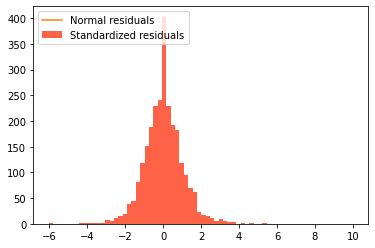

In [87]:
plt.hist(am_std_resid, bins = 50, facecolor='tomato', label='Standardized residuals')

In [88]:
skewt_gm = arch_model(returns, p=1, q=1, mean='constant', vol='GARCH', dist='skewt')
skewt_result = skewt_gm.fit()

Iteration:      1,   Func. Count:      8,   Neg. LLF: 63034.99535894247
Iteration:      2,   Func. Count:     20,   Neg. LLF: 157434.76185167383
Iteration:      3,   Func. Count:     30,   Neg. LLF: 36572.68356753818
Iteration:      4,   Func. Count:     39,   Neg. LLF: 13369.402937497587
Iteration:      5,   Func. Count:     47,   Neg. LLF: 4117.601945830269
Iteration:      6,   Func. Count:     55,   Neg. LLF: 1779.620284225798
Iteration:      7,   Func. Count:     63,   Neg. LLF: 3576.8967587639736
Iteration:      8,   Func. Count:     71,   Neg. LLF: 1777.638074304573
Iteration:      9,   Func. Count:     79,   Neg. LLF: 2212.9902287245
Iteration:     10,   Func. Count:     88,   Neg. LLF: 1777.6352953126157
Iteration:     11,   Func. Count:     96,   Neg. LLF: 1809.572279384653
Iteration:     12,   Func. Count:    105,   Neg. LLF: 1774.2407422933072
Iteration:     13,   Func. Count:    112,   Neg. LLF: 1774.2389713604637
Iteration:     14,   Func. Count:    119,   Neg. LLF: 1774.2

In [89]:
print(skewt_result.summary())

                           Constant Mean - GARCH Model Results                           
Dep. Variable:                           DEXKOUS   R-squared:                      -0.000
Mean Model:                        Constant Mean   Adj. R-squared:                 -0.000
Vol Model:                                 GARCH   Log-Likelihood:               -1774.24
Distribution:      Standardized Skew Student's t   AIC:                           3560.48
Method:                       Maximum Likelihood   BIC:                           3595.68
                                                   No. Observations:                 2609
Date:                           Fri, Nov 06 2020   Df Residuals:                     2603
Time:                                   20:16:26   Df Model:                            6
                                  Mean Model                                  
                  coef    std err          t      P>|t|       95.0% Conf. Int.
--------------------------------

In [97]:
cmean_model = arch_model(returns, p=1,q=1, mean='Constant', vol='GARCH', dist='normal')
armean_model = arch_model(returns, p=1,q=1, mean='AR', vol='GARCH', dist='normal')
cmean_res = cmean_model.fit()



Iteration:      1,   Func. Count:      6,   Neg. LLF: 6642612854.956478
Iteration:      2,   Func. Count:     15,   Neg. LLF: 1489707451.7033625
Iteration:      3,   Func. Count:     24,   Neg. LLF: 6313160.835938742
Iteration:      4,   Func. Count:     30,   Neg. LLF: 1874.876150886485
Iteration:      5,   Func. Count:     36,   Neg. LLF: 1877.8503615917778
Iteration:      6,   Func. Count:     42,   Neg. LLF: 1873.7797699730995
Iteration:      7,   Func. Count:     48,   Neg. LLF: 2010.0149672412126
Iteration:      8,   Func. Count:     55,   Neg. LLF: 1861.3760701121003
Iteration:      9,   Func. Count:     61,   Neg. LLF: 1856.7977368721213
Iteration:     10,   Func. Count:     67,   Neg. LLF: 1856.2946457312141
Iteration:     11,   Func. Count:     72,   Neg. LLF: 1856.2946065544775
Iteration:     12,   Func. Count:     76,   Neg. LLF: 1856.2946065521537
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1856.2946065544775
            Iterat

In [98]:
armean_res = armean_model.fit()

Iteration:      1,   Func. Count:      6,   Neg. LLF: 6642612854.956478
Iteration:      2,   Func. Count:     15,   Neg. LLF: 1489707451.7033625
Iteration:      3,   Func. Count:     24,   Neg. LLF: 6313160.835938742
Iteration:      4,   Func. Count:     30,   Neg. LLF: 1874.876150886485
Iteration:      5,   Func. Count:     36,   Neg. LLF: 1877.8503615917778
Iteration:      6,   Func. Count:     42,   Neg. LLF: 1873.7797699730995
Iteration:      7,   Func. Count:     48,   Neg. LLF: 2010.0149672412126
Iteration:      8,   Func. Count:     55,   Neg. LLF: 1861.3760701121003
Iteration:      9,   Func. Count:     61,   Neg. LLF: 1856.7977368721213
Iteration:     10,   Func. Count:     67,   Neg. LLF: 1856.2946457312141
Iteration:     11,   Func. Count:     72,   Neg. LLF: 1856.2946065544775
Iteration:     12,   Func. Count:     76,   Neg. LLF: 1856.2946065521537
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1856.2946065544775
            Iterat

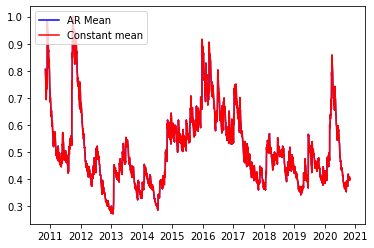

In [99]:
plt.plot(armean_res.conditional_volatility, color='blue', label='AR Mean')
plt.plot(cmean_res.conditional_volatility, color='red', label='Constant mean')
plt.legend(loc='upper left')
plt.show()

In [100]:
print(np.corrcoef(armean_res.conditional_volatility, cmean_res.conditional_volatility)[0,1])

1.0
